# Chapter 2: End-to-end Machine Learning project

*Based on the [book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) and [this notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) by the book's author.*

---

Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

Here are the main steps you will go through:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

## Look at the big picture

### The data

- This data has metrics such as the population, median income, median housing price, and so on for each block group in California.
- Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short.
- Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

### Frame the problem

#### 1) Objective

Start by asking question such as:

1. Ask your boss "what exactly is the business objective?". (Building a model is probably not the end goal.)
2. How does the company expect to use and benefit from this model?


This is important because it will determine:

> - how you **frame the problem**, 
> - what **algorithms** you will select, 
> - what **performance measure** you will use to evaluate your model, 
> - and **how much effort** you should spend tweaking it.

Your boss answers that:

> "Your model's output (a prediction of a district's median housing
price) will be **fed to another Machine Learning system**, along
with many other signals. This downstream system will determine **whether it is worth
investing in a given area or not**. Getting this right is critical, as it **directly affects revenue**."

#### 2) Assess current solution

**Question:** Ask what the current solution looks like (if any)?

**Answer:** Estimated manually by experts using complex rules. Costly and time-consuming. Their estimates are usually off by more than 20%. 

#### 3) Design your system

- <u>Supervised learning task:</u> because you are given labeled training examples.
- <u>Regression task:</u> since you are asked to predict a value.
  - *Multiple regression* problem since the system will use multiple features to make a prediction.
  - *Univariate regression* problem since the goal is to predict a single value for each district (if multiple outputs, *multivariate regression*).
- <u>Batch learning:</u> there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory.

> If the data was huge, you could either split your batch learning
work across multiple servers (using the MapReduce technique), or
you could use an online learning technique instead.

### Select a Performance metric 

Root Mean Squared Error (RMSE)

$ \text{RMSE}(\mathbf{X}, h) = \sqrt{ \dfrac{1}{m} \sum_{i=1}^{m} \left( h (\mathbf{x}^{(i)}) - y^{(i)} \right) ^2 } $


- Commom for regression problems
- Gives higher weight for large errors

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
x = np.arange(0, 20, 0.1)

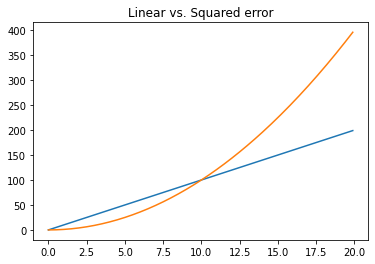

In [14]:
plt.plot(x,10*x)
plt.plot(x,x**2)
plt.title("Linear vs. Squared error")
plt.show()

> The higher the error, the higher the RMSE, because the *weight* is the error itself (quadratic function).

In some cases you may want to use MAE (Mean Absolute Error).

For example, suppose that there are many outlier districts.

$ \text{MAE}(\mathbf{X}, h) = \dfrac{1}{m} \sum_{i=1}^{m} \left| h (\mathbf{x}^{(i)}) - y^{(i)} \right|$


#### Analysing which norm/distance measure to use
>
> The higher the norm index (1 for MAE, 2 for RMSE), the more it focuses on large values and neglects small ones. 
>
> This is why the RMSE is more sensitive to outliers than the MAE. 
>
> But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred.


### Check the Assumptions

Lastly, it is good practice to list and verify the assumptions that were made so far (by
you or others); this can catch serious issues early on.

**Example:** 
> what if the downstream system that will use your predictions actually converts the prices into categories (e.g., “cheap”, “medium” or “expensive”)? 
>
> And then uses those categories instead of the prices themselves?
>
> **The problem should have been framed as a classification task, not a regression task.**

Fortunately, your assumptions are correct! Great! You can start coding now.

## Get the data

In [112]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [30]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [18]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [60]:
import tarfile
import urllib.request

HOUSING_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets", "housing")

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        print("Creating HOUSING_PATH...")
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [61]:
fetch_housing_data()

In [62]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [63]:
housing = load_housing_data()
housing.tail()
# Each row represents one district

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


## Take a Quick Look at the Data Structure

In [65]:
housing.info()
# only 'total_bedrooms' column has null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [69]:
# Checking null values
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [71]:
# all columns are numeric, except 'ocean_proximity'
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

<AxesSubplot:>

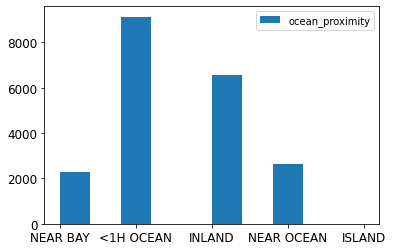

In [117]:
housing["ocean_proximity"].hist(grid=False, legend=True)

In [118]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<BarContainer object of 5 artists>

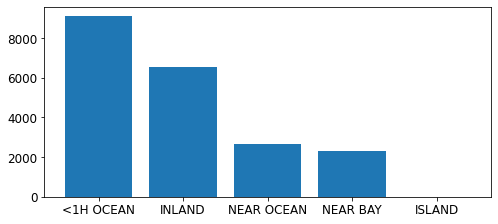

In [119]:
counts = housing["ocean_proximity"].value_counts().reset_index()
plt.figure(figsize=(8, 3.5))
plt.bar(counts.iloc[:, 0], counts.iloc[:, 1])

In [120]:
# summary of numerical fields with describe()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [128]:
# max value of 'total_bedrooms'
housing[housing["total_bedrooms"] == 6445]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN


**Visualizing same information with chart: Boxplot**

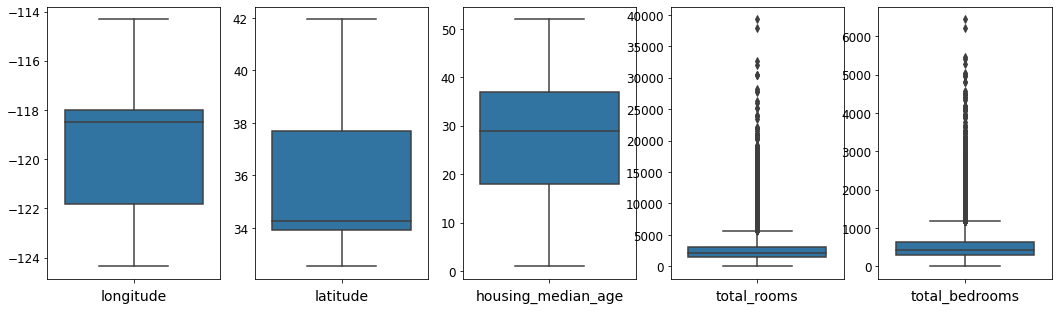

In [153]:
selection = list(housing.columns)[:5]
fig, axes = plt.subplots(1, len(selection), figsize=(18, 5))
for i, col in enumerate(selection):
    ax = sns.boxplot(y=housing[col], ax=axes.flatten()[i])
    ax.set_ylabel('')
    ax.set_xlabel(col)
plt.show()

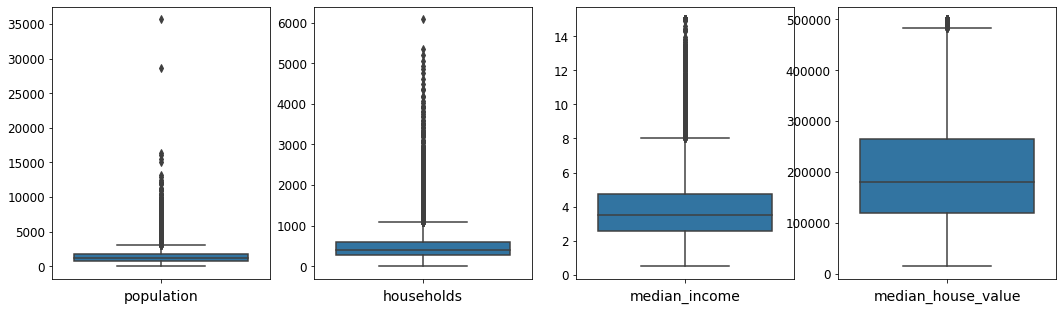

In [154]:
selection = list(housing.columns)[5:-1]
fig, axes = plt.subplots(1, len(selection), figsize=(18, 5))
for i, col in enumerate(selection):
    ax = sns.boxplot(y=housing[col], ax=axes.flatten()[i])
    ax.set_ylabel('')
    ax.set_xlabel(col)
plt.show()

**A histogram for each numerical attribute**

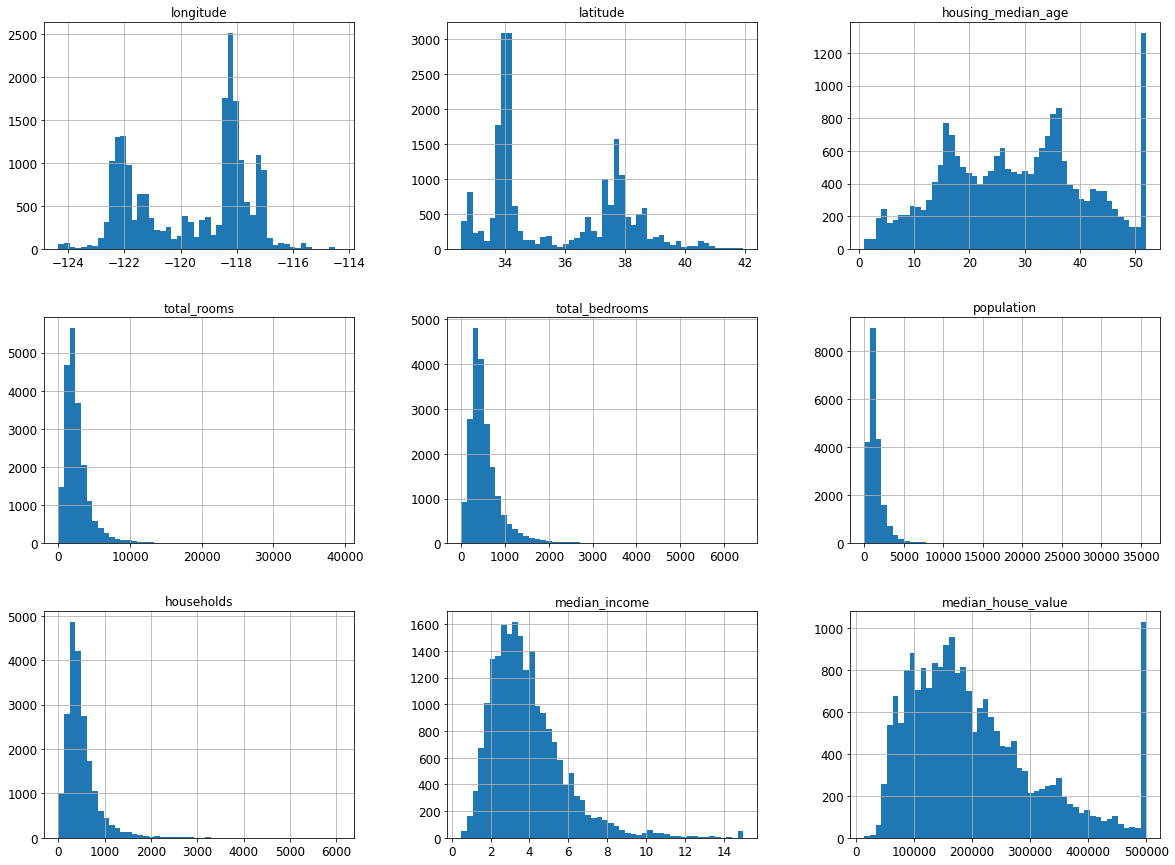

In [157]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Important things to notice

1. The `median income` attribute was scaled and caped. The limits are [0.5, 15], which means any values bellow or above were converted to the boundary value. The value was scaled by 10,000, so 3 actually means USD $30,000. This is not necessarily a problem, but you should try to understand how the data was computed.

2. The `housing median age` and the `median house value` were also capped. The latter may be a serious problem since it is your target attribute. You need to check with your client team if this is a problem or not. If they tell you that they need precise predictions even beyond USD 500,000, then you have mainly two options:

    a. Collect proper labels for the districts whose labels were capped.  
    b. Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

3. These attributes have very different scales. They may need some feature scaling process.

4. Finally, many histograms are "tail heavy". This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions (Gaussian).

## Create a Test Set

Why separate it at this moment? 

> Your brain is an amazing pattern detection system, which means that it is highly
prone to overfitting: if you look at the test set, you may stumble upon some seemingly
interesting pattern in the test data that leads you to select a particular kind of
Machine Learning model.

If you don't separate it early, you have a risk of chosing a model that will have good generalization error on the testing set, but won't perform as well as expected when you launch it into production.

### First possibility

In [162]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio, random_state=None):
    if random_state:
        np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [163]:
train_set, test_set = split_train_test(housing, 0.2, random_state=42)
print('train:', len(train_set), '| test:', len(test_set))

train: 16512 | test: 4128


### Second possibility

To use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). This can be done using a hash function.

In [178]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [179]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [180]:
print('train:', len(train_set), '| test:', len(test_set))

train: 16512 | test: 4128


Using an ID that is more stable and easily maintened than generating a row index: 

> combining latitude and longitude

In [181]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [184]:
print('train:', len(train_set), '| test:', len(test_set))
# PS: maybe not very good identifier. Split was different.

train: 16322 | test: 4318


In [185]:
housing_with_id[['longitude', 'latitude', 'id']].head()

,longitude,latitude,id
0,-122.23,37.88,-122192.12
1,-122.22,37.86,-122182.14
2,-122.24,37.85,-122202.15
3,-122.25,37.85,-122212.15
4,-122.25,37.85,-122212.15


### Using sklearn function `train_test_split`

In [186]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [187]:
print('train:', len(train_set), '| test:', len(test_set))

train: 16512 | test: 4128
